In [1]:
!nvidia-smi

Wed Dec  2 11:16:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import albumentations as A

In [2]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels=None):
    super(DoubleConv, self).__init__()
    if not mid_channels:
      mid_channels = out_channels
    self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(mid_channels)
    self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = F.relu(self.conv1(x), inplace=True)
    x = self.bn1(x)
    x = F.relu(self.conv2(x), inplace=True)
    x = self.bn2(x)
    return x

class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Down, self).__init__()
    self.pool = nn.MaxPool2d(2)
    self.doubConv = DoubleConv(in_channels, out_channels)
  
  def forward(self, x):
    return self.pool(self.doubConv(x))


class Up(nn.Module):
  def __init__(self, in_channels, out_channels, bilinear=True):
    super(Up, self).__init__()
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
    else:
      self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)

class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

In [3]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear=True):
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.inc = DoubleConv(n_channels, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    factor = 2 if bilinear else 1
    self.down4 = Down(512, 1024 // factor)
    self.up1 = Up(1024, 512 // factor, bilinear)
    self.up2 = Up(512, 256 // factor, bilinear)
    self.up3 = Up(256, 128 // factor, bilinear)
    self.up4 = Up(128, 64, bilinear)
    self.outc = OutConv(64, n_classes)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

Testing

In [4]:
import numpy as np
class Config:
    root_path = '/content/drive/MyDrive/Deep_learning/Dataset/Hubmap-kidney-segmentation'
    seed = 55
    custom_colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#8000FF', '#F400FF']
    images_path = '/content/drive/MyDrive/Deep_learning/Dataset/Hubmap256x256/train'
    masks_path = '/content/drive/MyDrive/Deep_learning/Dataset/Hubmap256x256/masks'
    img_size = 256
    pretrained_model_path = None
    train_logs_path = None
    test_csv_path = ''
    
def seed_everything(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
       
config = Config()
seed_everything(config.seed) 

In [5]:
import os
import pandas as pd
import cv2

mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

def img2tensor(img, dtype:np.dtype=np.float32):
  if img.ndim==2 : img = np.expand_dims(img, 2)
  img = np.transpose(img, (2, 0, 1))
  return torch.from_numpy(img.astype(dtype, copy=False))

def get_augmentation(phase: str='train'):
  if phase == 'train':
    list_transform = [
      A.HorizontalFlip(),
      A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness()
      ], p=0.3),
      A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03),
        A.GridDistortion(),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5)
      ], p=0.3),
      A.ShiftScaleRotate(p=0.2),
      A.Resize(config.img_size, config.img_size, always_apply=True),
    ]
  else: 
    list_transform = [
      A.Resize(config.img_size, config.img_size)
    ]
  return A.Compose(list_transform)

class HuBMAPDataset(Dataset):
  def __init__(self, ids, phase):
    self.ids = ids
    self.augmentations = get_augmentation(phase)

  def __getitem__(self, idx):
    name = self.ids[idx]
    img = cv2.imread(f'{config.images_path}/{name}').astype('float32')
    img /= 255.
    mask = cv2.imread(f'{config.masks_path}/{name}')[:, :, 0:1]
    augmented = self.augmentations(image=img, mask=mask)
    img = augmented['image']
    mask = augmented['mask']
    img = img.transpose(2, 0, 1).astype('float32')
    mask = mask.transpose(2, 0, 1).astype('float32')
    return img, mask

  def __len__(self):
    return len(self.ids)


def get_dataloader(phase: str = 'train', batch_size: int = 8, num_workers: int = 6, val_size: float = 0.2, fold: int = 0 ): 
  ids = os.listdir(config.images_path)
  train_data = pd.DataFrame(ids, columns=['ids'])
  skf = KFold(n_splits=7, random_state=config.seed, shuffle=True)
  for i, (train_index, val_index) in enumerate(skf.split(train_data, train_data)):
    train_data.loc[val_index, 'fold'] = i
    train_df = train_data.loc[train_data['fold'] != fold].reset_index(drop=True)
    val_df = train_data.loc[train_data['fold'] == fold].reset_index(drop=True)
    ids = train_df['ids'].tolist() if phase == 'train' else val_df['ids'].tolist()
    image_dataset = HuBMAPDataset(ids, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers= num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader


In [6]:
val_dataloader = get_dataloader(phase='train')
imgs, masks = next(iter(val_dataloader))
print('images -> ', imgs.shape, imgs.dtype)
print('masks -> ', masks.shape, masks.dtype)

images ->  torch.Size([8, 3, 256, 256]) torch.float32
masks ->  torch.Size([8, 1, 256, 256]) torch.float32


In [7]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor, 
                     threshold: float=0.5,
                     eps: float=1e-9) -> np.ndarray:
  scores = []
  num = probabilities.shape[0]
  predictions = (probabilities >= threshold).float()
  assert(predictions.shape == truth.shape)
  for i in range(num):
    prediction = predictions[i]
    truth_ = truth[i]
    intersection = 2.0 * (truth_*prediction).sum()
    union = truth_.sum() + prediction.sum()
    if truth_.sum() == 0 and prediction.sum() == 0:
      scores.append(1.0)
    else:
      scores.append((intersection+eps) / union)
  return np.mean(scores)

In [8]:
class Meter:
  def __init__(self, threshold: float=0.5):
    self.threshold = threshold
    self.dice_scores = []
  
  def update(self, logits: torch.Tensor, targets: torch.Tensor):
    probs = torch.sigmoid(logits)
    dice = dice_coef_metric(probs, targets, self.threshold)
    self.dice_scores.append(dice)
  
  def get_metrics(self) -> np.ndarray:
    dice = np.mean(self.dice_scores)
    return dice

In [9]:
class DiceLoss(nn.Module):
  def __init__(self, eps=1e-9):
    super(DiceLoss, self).__init__()
    self.eps = eps

  def forward(self, logits, targets):
    num = targets.size(0)
    probability = torch.sigmoid(logits)
    probability = probability.view(num, -1)
    targets = targets.view(num, -1)
    assert(probability.shape == targets.shape)
    intersection = 2.0*(probability*targets).sum()
    union = probability.sum() + targets.sum()
    dice_score = (intersection +self.eps) / union
    return 1.0 - dice_score

In [10]:
import time

class Trainer:
  def __init__(self,
               model: nn.Module,
               metric: nn.Module,
               lr: float,
               accumulation_steps: int,
               batch_size: int,
               num_epochs: int,
               verbose: bool=True,
               n_fold: int = 0):
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('device: ', self.device)
    self.verbose = verbose
    self.model = model
    self.model = self.model.to(self.device)
    self.metric = metric
    self.optimizer = Adam(self.model.parameters(), lr=lr)
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', patience=3, verbose=True)
    self.accumulation_steps = accumulation_steps // batch_size
    self.phases = ['train', 'val']
    self.num_epochs = num_epochs
    self.dataLoaders = {
        phase: get_dataloader(phase=phase, batch_size=16, num_workers=4) for phase in self.phases
    }
    self.best_loss = float('inf')
    self.losses = {phase: [] for phase in self.phases}
    self.dice_score = {phase: [] for phase in self.phases}

  def compute_loss_and_output(self, images, masks):
    images = images.to(self.device)
    masks = masks.to(self.device)
    logits = self.model(images)
    loss = self.metric(logits, masks)
    return loss, logits

  def train_epoch(self, epoch, phase):
    print(f'{phase} epoch: {epoch}')
    self.model.train() if phase == 'train' else self.model.eval()
    meter = Meter()
    dataloader = self.dataLoaders[phase]
    total_batches = len(dataloader)
    running_loss = 0.0
    self.optimizer.zero_grad()
    for i, (images, targets) in enumerate(dataloader):
      loss, logits = self.compute_loss_and_output(images, targets)
      loss = loss / self.accumulation_steps
      if phase == 'train':
        loss.backward()
        if (i+1) % self.accumulation_steps == 0:
          self.optimizer.step()
          self.optimizer.zero_grad()
      running_loss += loss.item()
      meter.update(logits.detach().cpu(), targets.detach().cpu())
    epoch_loss = (running_loss * self.accumulation_steps) / total_batches
    epoch_dice = meter.get_metrics()
    self.losses[phase].append(epoch_loss)
    self.dice_score[phase].append(epoch_dice)
    return epoch_loss

  def train(self):
    for epoch in range(self.num_epochs):
      self.train_epoch(epoch, 'train')
      with torch.no_grad():
        val_loss = self.train_epoch(epoch,'val')
        self.scheduler.step(val_loss)
      if self.verbose:
        self.plot_history()
      if val_loss < self.best_loss:
        self.best_loss = val_loss
        torch.save(self.model.state_dict(), 'best_model.pth')
        print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
      # print()
    self.save_history()
    
  def plot_history(self):
    data = [self.losses, self.dice_score]
    colors = ['deepskyblue', 'crimson']
    labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_score['train'][-1]}
            val dice score {self.dice_score['val'][-1]} 
            """, 
    ]

    clear_output(True)
    with plt.style.context("seaborn-dark-palette"):
      fig, axes = plt.subplots(2, 1, figsize=(8, 10))
      for i, ax in enumerate(axes):
        ax.plot(data[i]['val'], c=colors[0], label="val")
        ax.plot(data[i]['train'], c=colors[-1], label="train")
        ax.set_title(labels[i])
        ax.legend(loc="upper right")
      plt.tight_layout()
      plt.show()

  def save_history(self):
    torch.save(self.model.state_dict(), f"last_epoch_model.pth")
    logs_ = [self.losses, self.dice_score]
    log_names_ = ["_loss", "_dice"]
    logs = [logs_[i][key] for i in list(range(len(logs_))) for key in logs_[i]]
    log_names = [key+log_names_[i] for i in list(range(len(logs_))) for key in logs_[i]]
    pd.DataFrame(dict(zip(log_names, logs))).to_csv("train_log.csv", index=False)

  def load_pretrained_model(self, model_path):
    self.model.load_state_dict(torch.load(model_path))
    print('Pretrained model loaded.')
  


In [11]:
model = UNet(3, 1)


In [12]:
print(model)

UNet(
  (inc): DoubleConv(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down1): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (doubConv): DoubleConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down2): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (doubConv): DoubleConv(
   

In [13]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

17267393


In [14]:
trainer = Trainer(model=model, 
                  metric=DiceLoss(), 
                  lr=5e-4, 
                  accumulation_steps=32, 
                  batch_size=8,
                  num_epochs=30,
                  n_fold=0)

device:  cuda


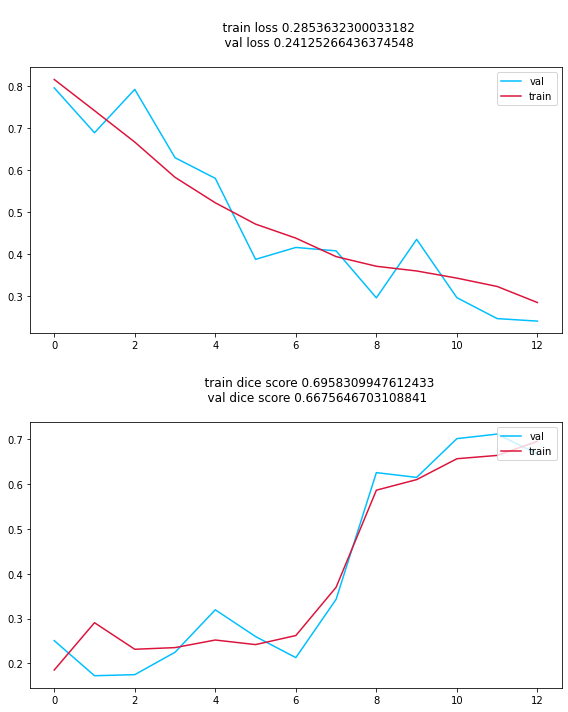


####################
Saved new checkpoint
####################

train epoch: 13


In [ ]:
trainer.train()